# UFF model creation

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import uff
import tensorflow as tf

In [2]:
model = tf.keras.applications.VGG16(include_top=True)

In [3]:
model.load_weights('/home/ <username> /.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

In [4]:
model_input = model.input.name.strip(':0')
model_output = model.output.name.strip(':0')

print(model_input, model_output)

(u'input_1', u'predictions/Softmax')


In [5]:
input_size = model.input.shape
print(input_size)

(?, 224, 224, 3)


In [6]:
graph = tf.get_default_graph().as_graph_def()

In [7]:
# graph

In [8]:
sess = tf.keras.backend.get_session()

In [9]:
frozen_graph = tf.graph_util.convert_variables_to_constants(sess, graph, [model_output])
frozen_graph = tf.graph_util.remove_training_nodes(frozen_graph)

INFO:tensorflow:Froze 32 variables.
Converted 32 variables to const ops.


In [10]:
uff_model = uff.from_tensorflow(frozen_graph, [model_output])

Using output node predictions/Softmax
Converting to UFF graph
No. nodes: 95


In [11]:
dump = open('VGG16.uff', 'wb')
dump.write(uff_model)
dump.close()

----------
### restart kernel!
----

# UFF model inference using TensorRT

In [1]:
import pycuda.driver as cuda
import pycuda.autoinit
import argparse
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

import tensorrt as trt
from tensorrt.parsers import uffparser

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Run inference on device
def infer(context, input_img, batch_size):
    # load engine
    engine = context.get_engine()
    assert(engine.get_nb_bindings() == 2)
    # create output array to receive data
    dims = engine.get_binding_dimensions(1).to_DimsCHW()
    elt_count = dims.C() * dims.H() * dims.W() * batch_size
    # convert input data to Float32
    input_img = input_img.astype(np.float32)
    # Allocate pagelocked memory
    output = cuda.pagelocked_empty(elt_count, dtype=np.float32)

    # alocate device memory
    d_input = cuda.mem_alloc(batch_size * input_img.size * input_img.dtype.itemsize)
    d_output = cuda.mem_alloc(batch_size * output.size * output.dtype.itemsize)

    bindings = [int(d_input), int(d_output)]

    stream = cuda.Stream()

    # transfer input data to device
    cuda.memcpy_htod_async(d_input, input_img, stream)
    # execute model
    context.enqueue(batch_size, bindings, stream.handle, None)
    # transfer predictions back
    cuda.memcpy_dtoh_async(output, d_output, stream)

    # return predictions
    return output

In [3]:
uff_model = open('VGG16.uff', 'rb').read()

In [4]:
parser = uffparser.create_uff_parser()
parser.register_input("input_1", (3, 224, 224), 0)
parser.register_output("predictions/Softmax")

True

In [5]:
trt_logger = trt.infer.ConsoleLogger(trt.infer.LogSeverity.INFO)

engine = trt.utils.uff_to_trt_engine(logger=trt_logger,
                                     stream=uff_model,
                                     parser=parser,
                                     max_batch_size=1, # 1 sample at a time
                                     max_workspace_size= 1 << 30, # 1 GB GPU memory workspace
                                     datatype=trt.infer.DataType.FLOAT) # that's very cool, you can set precision

context = engine.create_execution_context()

-------

In [6]:
test_image = image.load_img('hot_dog.jpg', target_size=(224, 224, 3))
print(test_image.size)

(224, 224)


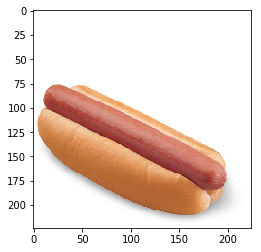

In [7]:
plt.imshow(test_image)

In [8]:
test_image = image.img_to_array(test_image)
processed_im = preprocess_input(np.expand_dims(test_image, 0))[0, :, :, :]
print(processed_im.shape)

(224, 224, 3)


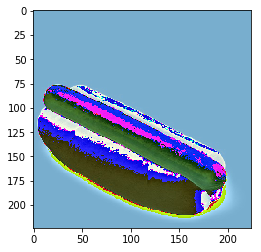

In [9]:
plt.imshow(processed_im)

In [10]:
processed_im = np.transpose(processed_im, axes=(2, 0, 1))
processed_im = processed_im.copy(order='C')
print(processed_im.shape)

(3, 224, 224)


In [11]:
prediction_proba = infer(context, processed_im, 1)
print(prediction_proba.shape)

(1000,)


In [12]:
decode_predictions(np.expand_dims(prediction_proba, 0))

[[(u'n07697537', u'hotdog', 0.94599628),
  (u'n07615774', u'ice_lolly', 0.012393792),
  (u'n07684084', u'French_loaf', 0.009682673),
  (u'n03676483', u'lipstick', 0.0058330344),
  (u'n03729826', u'matchstick', 0.0023167627)]]